In [14]:
#CLASE MLP_TODO.PY Y FUNCIONES AUXILIARES
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from time import time

# ====================================================
# Funciones para activación y  su derivada
# ====================================================
def cargar_dataset(ruta):
    # Cargar el archivo CSV con pandas
    datos = pd.read_csv(ruta)
    # Separar las características (todas menos la última columna)
    X = datos.iloc[:, :-1].values  
    # Separar la columna objetivo (última columna)
    y = datos.iloc[:, -1].values  
    # Asegurar que y sea un vector columna (n x 1)
    y = y.reshape(-1, 1)
    # Mostrar información del dataset cargado
    print(f"Conjunto de datos cargado desde: {ruta}")
    print(f"   → Ejemplos: {X.shape[0]}, Características: {X.shape[1]}")
    print(f"   → Clases únicas en y: {np.unique(y).ravel()}")

    return X, y


# Función de activación sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivada de la sigmoide
def sigmoid_derivative(x):
    # return sigmoid(x) * (1 - sigmoid(x))
    return x * (1 - x)

# ====================================================
# Funciones para manejo de la semilla
# ====================================================

# Establece la semilla para la generación de números aleatorios
def seed(random_state=33):
    np.random.seed(random_state)
    random.seed(random_state)

# ====================================================
# Funciones para inicialización y normalización
# ====================================================

# Inicialización Xavier
def xavier_initialization(input_size, output_size): 
    return np.random.randn(input_size, output_size) * np.sqrt(1 / input_size)
# Inicialización normal
def normal_initialization(input_size, output_size):
    return np.random.randn(input_size, output_size)
# Normalización Z-score
def zscore_normalization(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_norm = (X - mean) / std
    return X_norm

#Función para crear minibatches
def create_minibatches(X, y, batch_size):
    """
    Genera los lotes de datos (batchs) de acuerdo al parámetro batch_size de forma aleatoria para el procesamiento. 
    """
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)  # Mezcla los índices aleatoriamente
    X_shuffled, y_shuffled = X[indices], y[indices]  # Reordena X e y según los índices aleatorios
    
    # Divide los datos en minibatches
    for X_batch, y_batch in zip(np.array_split(X_shuffled, np.ceil(n_samples / batch_size)), 
                                np.array_split(y_shuffled, np.ceil(n_samples / batch_size))):
        yield X_batch, y_batch

    
class MLP_TODO:
    def __init__(self, num_entradas, num_neuronas_ocultas, num_salidas, epochs, batch_size=128, learning_rate=0.2, normalizacion="none",inicializacion="xavier",random_state=42):

        # ====================================================
        # Inicialización general del modelo
        # ====================================================

        # 🔹 NUEVO: Usar el parámetro random_state recibido para controlar la semilla
        seed(random_state)
        self.random_state = random_state  # 🔹 NUEVO: guardar la semilla para usarla también en create_minibatches

        # Definir la tasa de aprendizaje
        self.learning_rate = learning_rate
        # Definir el número de épocas
        self.epochs = epochs
        # Definir el tamaño del batch de procesamiento
        self.batch_size = batch_size
        # Definir el tipo de normalización
        self.normalizacion = normalizacion
        # Definir el tipo de inicialización
        self.inicializacion = inicializacion
        # definir las 
        self.num_neuronas_ocultas = num_neuronas_ocultas

        # Inicialización de pesos y bias
        self.W1 = self.inicializar_pesos(num_entradas, self.num_neuronas_ocultas) # Pesos entre capa de entrada y capa oculta
        self.b1 = np.zeros((1, self.num_neuronas_ocultas))   # Bias de la capa oculta
        self.W2 = self.inicializar_pesos(self.num_neuronas_ocultas,num_salidas)  # Pesos entre capa oculta y capa de salida
        self.b2 = np.zeros((1, num_salidas)) # Bias de la capa de salida

        # Historial de errores
        self.errores_history = []
        # Historial de accuracy
        self.accuracy_history = []

    # ====================================================
    # Funciones para forward, backward, update, predict y train
    # ====================================================

    def forward(self, X):
        #implementar el forward pass
        #----------------------------------------------
        # 1. Propagación hacia adelante (Forward pass)
        #----------------------------------------------
        # Calcular la suma ponderada Z (z_c1) para la capa oculta 
        self.X = X
        self.z_c1 = X@self.W1 + self.b1
        #Calcular la activación de la capa oculta usando la función sigmoide
        self.a_c1 = sigmoid(self.z_c1)  # Activación capa oculta
        #Calcular la suma ponderada Z (z_c2)  para la capa de salida 
        self.z_c2  = self.a_c1 @ self.W2 + self.b2
        #Calcular la activación de la capa de salida usando la función sigmoide
        y_pred = sigmoid(self.z_c2)  # Activación capa salida
        return y_pred
    

    def loss_function_MSE(self, y_pred, y):
        #----------------------------------------------
        # 2. Cálculo del error con MSE
        #----------------------------------------------
        #Calcular el error cuadrático medio (MSE)
        self.y_pred = y_pred
        self.y = y
        error = 0.5 * np.mean((y_pred - y) ** 2)
        return error
    

    def backward(self):
        #implementar el backward pass
        # calcular los gradientes para la arquitectura de la figura anterior
        #----------------------------------------------
        # 3. Propagación hacia atrás (Backward pass)
        #----------------------------------------------
        
        #----------------------------------------------
        # Gradiente de la salida
        #----------------------------------------------
        #Calcular la derivada del error con respecto a la salida y
        dE_dy_pred = (self.y_pred - self.y)  # Derivada del error respecto a la predicción con  N ejemplos
        #Calcular la derivada de la activación de la salida con respecto a z_c2 
        d_y_pred_d_zc2 = sigmoid_derivative(self.y_pred)
        #Calcular delta de la capa de salida
        delta_c2 = dE_dy_pred * d_y_pred_d_zc2  # (N, 1)

        #----------------------------------------------
        # Gradiente en la capa oculta
        #----------------------------------------------
        # calcular la derivada de las suma ponderada respecto a las activaciones de la capa 1
        d_zc2_d_a_c1 = self.W2  
        #Propagar el error hacia la capa oculta, calcular deltas de la capa 1
        delta_c1 = delta_c2 @ d_zc2_d_a_c1.T * sigmoid_derivative(self.a_c1)  

        #calcula el gradiente de la función de error respecto a los pesos de la capa 2
        self.dE_dW2 = self.a_c1.T @ delta_c2
        self.dE_db2 = np.sum(delta_c2, axis=0, keepdims=True)
        self.dE_dW1 = self.X.T @ delta_c1 
        self.dE_db1 = np.sum(delta_c1, axis=0, keepdims=True) 


    def update(self):  # Ejecución de la actualización de paramámetros
        #implementar la actualización de los pesos y el bias
        #----------------------------------------------
        # Actualización de pesos de la capa de salida
        #---------------------------------------------- 
        #Actualizar los pesos y bias de la capa de salida
        self.W2 = self.W2 - self.dE_dW2 * self.learning_rate
        self.b2 = self.b2 - self.dE_db2 * self.learning_rate
        #----------------------------------------------
        # Actuailzación de pesos de la capa oculta
        #----------------------------------------------
        #calcula el gradiente de la función de error respecto a los pesos de la capa 1
        self.W1 = self.W1 - self.dE_dW1 * self.learning_rate
        self.b1 = self.b1 - self.dE_db1 * self.learning_rate

    def predict(self, X):  # Predecir la categoría para datos nuevos
        # TODO: implementar la predicción 
        y_pred = self.forward(X)
        # Obtener la clase para el clasificador binario
        y_pred = np.where(y_pred >= 0.5, 1, 0)
        return y_pred

    def train(self, X, Y):
        #implementar el entrenamiento de la red
            # 🔹 Normalizar los datos según el tipo configurado
        X = self.normalize(X)
        for epoch in range(self.epochs):
            num_batch = 0
            epoch_error  = 0
            for X_batch, y_batch in create_minibatches(X, Y, self.batch_size):
                y_pred = self.forward(X_batch)
                error = self.loss_function_MSE(y_pred, y_batch)
                epoch_error += error    
                self.backward() # cálculo de los gradientes
                self.update() # actualización de los pesos y bias
                num_batch += 1
                # Imprimir el error cada N épocas
                if epoch % 100 == 0:
                    print(f"Época {epoch}, Error batch {num_batch}: {error}")
            # Guardar el error promedio de la época
            self.errores_history.append(epoch_error/num_batch)
            #Calcular Accuracy en todo el dataset
            acc_epoch = self.accuracy(X, Y)
            self.accuracy_history.append(acc_epoch)
            # Imprimir el error y accuracy cada N épocas
            if epoch % 100 == 0:
                    print(f"Época {epoch}, Error: {epoch_error/num_batch}%")

    def evaluar(self, X, y):
        """
        Evalúa el desempeño del modelo en un conjunto de prueba.
        Muestra todas las predicciones junto con las salidas esperadas en columnas paralelas.
        Calcula la precisión total.
        """
        # Normalizar los datos de entrada con la misma técnica usada en entrenamiento
        X = self.normalize(X)

        # Obtener las predicciones
        y_pred = self.predict(X)

        # Combinar esperadas y predicciones en columnas paralelas
        resultados = np.column_stack((y, y_pred))
        
        # Mostrar resultados
        print("\n🔍 Evaluación del modelo (esperada | predicha):")
        for idx, (esperada, predicha) in enumerate(resultados):
            print(f"{idx+1:02d}: {esperada} | {predicha}")

        # Calcular precisión global
        accuracy = np.mean(y_pred == y)
        print(f"\n✅ Precisión del modelo: {accuracy * 100:.2f}%")

        return accuracy


    
    # ====================================================
    # Funciones para inicialización, normalización y accuracy
    # ====================================================
    # Normalización de los datos
    def normalize(self, X):
        if self.normalizacion == "z-score":
            return zscore_normalization(X)  # 🔹 Llamada a la función existente
        else:  # sin normalizar
            return X
        
    # Inicialización de los pesos  
    def inicializar_pesos(self, tamaño_entrada, tamaño_salida):
        if self.inicializacion == "xavier":
            return xavier_initialization(tamaño_entrada, tamaño_salida)
        elif self.inicializacion == "normal":
            return normal_initialization(tamaño_entrada, tamaño_salida)
        else:
            raise ValueError("Tipo de inicialización no soportado")
    # Cálculo de accuracy    
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        acc = np.mean(y_pred == y)  # compara predicciones con valores reales
        return acc
    
    # ====================================================
    # Funciones para graficar Error, Acurery y ambas
    # ====================================================
    
    # Gráfica del error despues del entrenamiento
    def plot_error(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.errores_history, label="Error MSE", linewidth=2)
        plt.xlabel("Épocas")
        plt.ylabel("Error cuadrático medio (MSE)")
        #Título dinámico con configuración
        plt.title(f"Entrenamiento MLP - Capacas ocultas: {self.num_neuronas_ocultas}, Inicializacion: {self.inicializacion}, Normalización: {self.normalizacion}, "
                f"LR: {self.learning_rate}, Batch_size: {self.batch_size},Funcion de activacion: Sigmoid, Épocas: {self.epochs}")
        plt.legend()
        plt.grid(True)
        plt.show()
  
    

In [18]:
#Funciones para graficar resultados de múltiples experimentos
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Función para plotear errores agrupados por número de neuronas
def plot_error_por_neuronas(df_resultados):
    colores = {2:'blue', 4:'green', 8:'red', 16:'orange', 32:'purple', 128:'brown'}
    plt.figure(figsize=(12,6))
    for neuronas in sorted(set(df_resultados['Neuronas'])):
        df_neuronas = df_resultados[df_resultados['Neuronas']==neuronas]
        for _, fila in df_neuronas.iterrows():
            plt.plot(fila['Errores historial'], color=colores[neuronas], alpha=0.3)
    from matplotlib.lines import Line2D
    leyenda = [Line2D([0],[0],color=color,lw=2,label=f"{n} neuronas") for n,color in colores.items() if n in df_resultados['Neuronas'].values]
    plt.legend(handles=leyenda, fontsize=10)
    plt.xlabel("Épocas")
    plt.ylabel("Error MSE")
    plt.title("Evolución del Error MSE agrupado por número de neuronas")
    plt.grid(True)
    plt.show()


# Función para plotear errores agrupados por learning rate
def plot_error_por_learning_rate(df_resultados):
    colores = {0.01:'blue', 0.1:'green', 0.5:'red'}
    plt.figure(figsize=(12,6))
    for lr in sorted(set(df_resultados['Learning rate'])):
        df_lr = df_resultados[df_resultados['Learning rate']==lr]
        for _, fila in df_lr.iterrows():
            plt.plot(fila['Errores historial'], color=colores[lr], alpha=0.3)
    from matplotlib.lines import Line2D
    leyenda = [Line2D([0],[0],color=color,lw=2,label=f"LR={lr}") for lr,color in colores.items() if lr in df_resultados['Learning rate'].values]
    plt.legend(handles=leyenda, fontsize=10)
    plt.xlabel("Épocas")
    plt.ylabel("Error MSE")
    plt.title("Evolución del Error MSE agrupado por Learning Rate")
    plt.grid(True)
    plt.show()


# Función para plotear errores agrupados por batch size
def plot_error_por_batch(df_resultados):
    colores = {8:'blue', 16:'green', 32:'red', 64:'orange'}
    plt.figure(figsize=(12,6))
    for batch in sorted(set(df_resultados['Batch size'])):
        df_batch = df_resultados[df_resultados['Batch size']==batch]
        for _, fila in df_batch.iterrows():
            plt.plot(fila['Errores historial'], color=colores[batch], alpha=0.3)
    from matplotlib.lines import Line2D
    leyenda = [Line2D([0],[0],color=color,lw=2,label=f"Batch={b}") for b,color in colores.items() if b in df_resultados['Batch size'].values]
    plt.legend(handles=leyenda, fontsize=10)
    plt.xlabel("Épocas")
    plt.ylabel("Error MSE")
    plt.title("Evolución del Error MSE agrupado por Batch Size")
    plt.grid(True)
    plt.show()


# Heatmap del error final por combinaciones de neuronas y LR (por ejemplo)
def heatmap_error_final(df_resultados):
    pivot = df_resultados.pivot_table(index='Neuronas', columns='Learning rate', values='Error final', aggfunc='mean')
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis")
    plt.title("Heatmap del Error final (MSE) por Neuronas y Learning Rate")
    plt.show()


# Heatmap de la precisión por combinaciones de inicialización y normalización
def heatmap_init_norm(df_resultados):
    pivot = df_resultados.pivot_table(index='Inicialización', columns='Normalización', values='Accuracy', aggfunc='mean')
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Heatmap de Accuracy por Inicialización y Normalización")
    plt.show()

# Función para crear subplots de error por Neuronas, Learning Rate y Batch Size
def plot_error_subplots(df_resultados):
    """
    Crea una figura con 3 subplots mostrando la evolución del error MSE
    agrupada por Neuronas, Learning Rate y Batch Size.
    """

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # ----------------------------------------
    # 1️⃣ Error por número de neuronas
    # ----------------------------------------
    colores_neuronas = {2:'blue', 4:'green', 8:'red', 16:'orange', 32:'purple', 128:'brown'}
    ax = axes[0]
    for neuronas in sorted(set(df_resultados['Neuronas'])):
        df_neuronas = df_resultados[df_resultados['Neuronas']==neuronas]
        for _, fila in df_neuronas.iterrows():
            ax.plot(fila['Errores historial'], color=colores_neuronas[neuronas], alpha=0.3)
    leyenda = [Line2D([0],[0],color=color,lw=2,label=f"{n} neuronas") 
               for n,color in colores_neuronas.items() if n in df_resultados['Neuronas'].values]
    ax.legend(handles=leyenda, fontsize=10)
    ax.set_title("Error por Neuronas")
    ax.set_xlabel("Épocas")
    ax.set_ylabel("MSE")
    ax.grid(True)

    # ----------------------------------------
    # 2️⃣ Error por Learning Rate
    # ----------------------------------------
    colores_lr = {0.01:'blue', 0.1:'green', 0.5:'red'}
    ax = axes[1]
    for lr in sorted(set(df_resultados['Learning rate'])):
        df_lr = df_resultados[df_resultados['Learning rate']==lr]
        for _, fila in df_lr.iterrows():
            ax.plot(fila['Errores historial'], color=colores_lr[lr], alpha=0.3)
    leyenda = [Line2D([0],[0],color=color,lw=2,label=f"LR={lr}") 
               for lr,color in colores_lr.items() if lr in df_resultados['Learning rate'].values]
    ax.legend(handles=leyenda, fontsize=10)
    ax.set_title("Error por Learning Rate")
    ax.set_xlabel("Épocas")
    ax.set_ylabel("MSE")
    ax.grid(True)

    # ----------------------------------------
    # 3️⃣ Error por Batch Size
    # ----------------------------------------
    colores_batch = {8:'blue', 16:'green', 32:'red', 64:'orange'}
    ax = axes[2]
    for batch in sorted(set(df_resultados['Batch size'])):
        df_batch = df_resultados[df_resultados['Batch size']==batch]
        for _, fila in df_batch.iterrows():
            ax.plot(fila['Errores historial'], color=colores_batch[batch], alpha=0.3)
    leyenda = [Line2D([0],[0],color=color,lw=2,label=f"Batch={b}") 
               for b,color in colores_batch.items() if b in df_resultados['Batch size'].values]
    ax.legend(handles=leyenda, fontsize=10)
    ax.set_title("Error por Batch Size")
    ax.set_xlabel("Épocas")
    ax.set_ylabel("MSE")
    ax.grid(True)

    plt.tight_layout()
    plt.show()



In [ ]:
#Hiperparámetros, carga de datos,entrenamiento,evaluacion y almacenamiento de resultados
import matplotlib.pyplot as plt
import pandas as pd
from time import time

# ===============================================
# Hiperparámetros 
# ===============================================
neuronas_ocultas = [2, 4, 8, 16, 32, 128]
inicializaciones = ["normal", "xavier"]
normalizaciones = ["none", "z-score"]
learning_rates = [0.01, 0.1, 0.5]
batch_sizes = [8, 16, 32, 64]
epochs = 2000  # puedes usar menos si el entrenamiento tarda mucho

# ===============================================
# Cargar datasets
# ===============================================
X_train, y_train = cargar_dataset("./iris_train.csv")
X_test, y_test = cargar_dataset("./iris_test.csv")

# ===============================================
# Lista para almacenar resultados
# ===============================================
resultados = []

# ===============================================
# Entrenamiento con todas las combinaciones
# ===============================================
for neuronas in neuronas_ocultas:
    for init in inicializaciones:
        for norm in normalizaciones:
            for lr in learning_rates:
                for batch in batch_sizes:

                    print(f"\n🔹 Entrenando -> N={neuronas}, Init={init}, Norm={norm}, LR={lr}, Batch={batch}")

                    # Crear el modelo
                    modelo = MLP_TODO(
                        num_entradas=X_train.shape[1],
                        num_neuronas_ocultas=neuronas,
                        num_salidas=1,
                        epochs=epochs,
                        batch_size=batch,
                        learning_rate=lr,
                        normalizacion=norm,
                        inicializacion=init
                    )

                    # Entrenamiento
                    inicio = time()
                    modelo.train(X_train, y_train)
                    duracion = round(time() - inicio, 2)

                    # Predicciones y métricas
                    y_pred = modelo.predict(X_test)
                    acc = np.mean(y_pred == y_test)
                    error_final = modelo.loss_function_MSE(y_pred, y_test)

                    # Guardar resultados
                    resultados.append({
                        "Neuronas": neuronas,
                        "Inicialización": init,
                        "Normalización": norm,
                        "Learning rate": lr,
                        "Batch size": batch,
                        "Accuracy": acc,
                        "Error final": error_final,   
                        "Tiempo (s)": duracion,
                        "Errores historial": modelo.errores_history
                    })

# ===============================================
# Crear DataFrame y seleccionar top 5 por Accuracy
# ===============================================
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="Accuracy", ascending=False)

Conjunto de datos cargado desde: ./iris_train.csv
   → Ejemplos: 80, Características: 4
   → Clases únicas en y: [0 1]
Conjunto de datos cargado desde: ./iris_test.csv
   → Ejemplos: 20, Características: 4
   → Clases únicas en y: [0 1]

🔹 Entrenando -> N=2, Init=normal, Norm=none, LR=0.01, Batch=8
Época 0, Error batch 1: 0.12584228340521908
Época 0, Error batch 2: 0.12801793937924089
Época 0, Error batch 3: 0.12888664655479254
Época 0, Error batch 4: 0.12492872628796552
Época 0, Error batch 5: 0.1275432266630851
Época 0, Error batch 6: 0.12448627957161754
Época 0, Error batch 7: 0.12552628365219165
Época 0, Error batch 8: 0.12392239490444217
Época 0, Error batch 9: 0.12437109244843689
Época 0, Error batch 10: 0.12814715167725
Época 0, Error: 0.12616720245442412%
Época 100, Error batch 1: 0.1251645675445451
Época 100, Error batch 2: 0.12514961216163104
Época 100, Error batch 3: 0.12488603822659013
Época 100, Error batch 4: 0.12577578223179822
Época 100, Error batch 5: 0.125780967093207

In [16]:
#Guardar resultados en CSV y Excel 
# Seleccionar todas las columnas excepto 'Errores historial'
df_guardar = df_resultados.drop(columns=['Errores historial'])

# Guardar en CSV
df_guardar.to_csv("resultados_mlp_sin_historial.csv", index=False)
print("✅ Resultados guardados en 'resultados_mlp_sin_historial.csv' (sin historial de errores)")

# Guardar en Excel
#df_guardar.to_excel("resultados_mlp_sin_historial.xlsx", index=False)
#print("✅ Resultados guardados en 'resultados_mlp_sin_historial.xlsx' (sin historial de errores)")


✅ Resultados guardados en 'resultados_mlp_sin_historial.csv' (sin historial de errores)


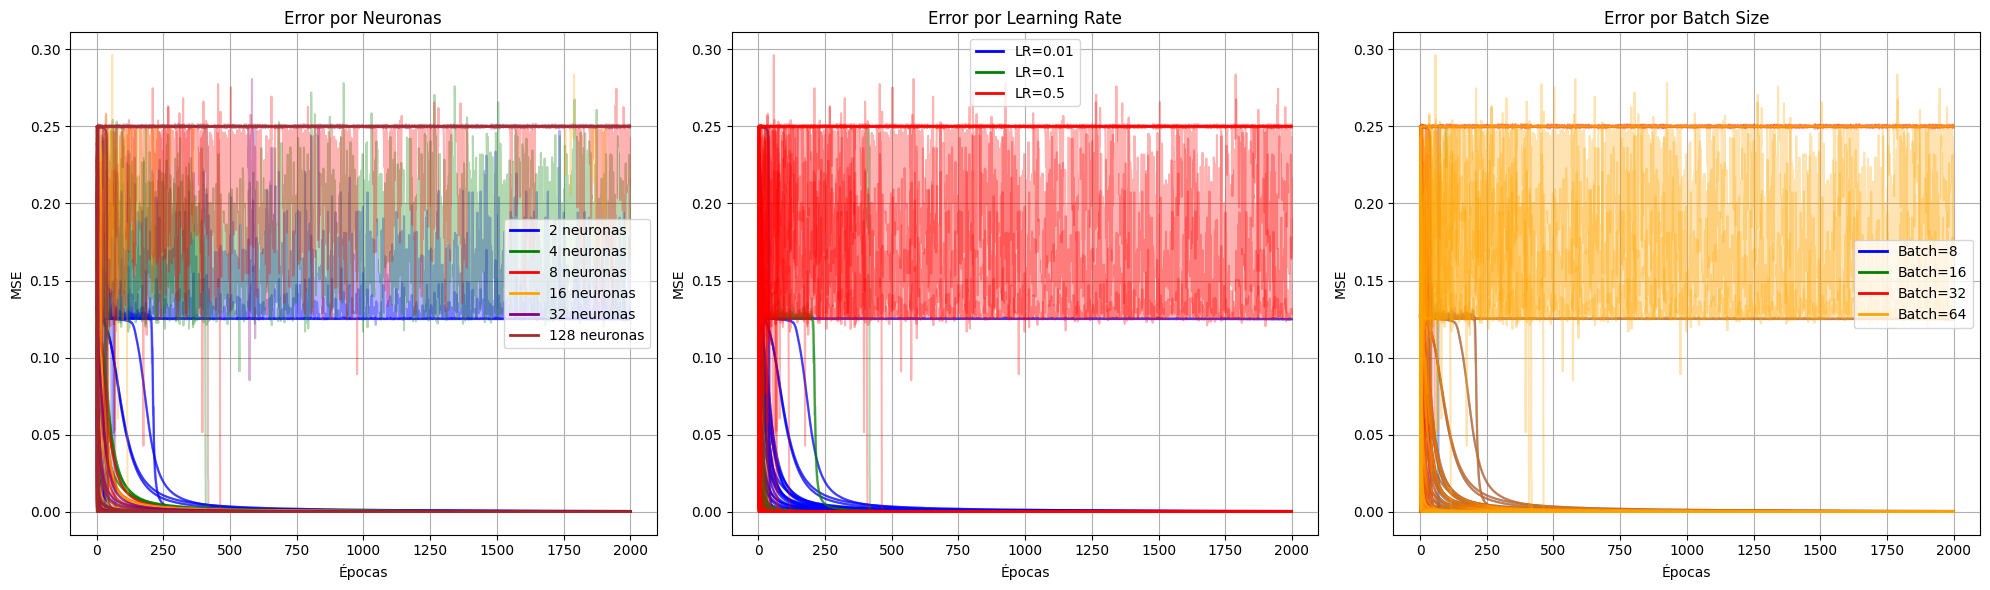

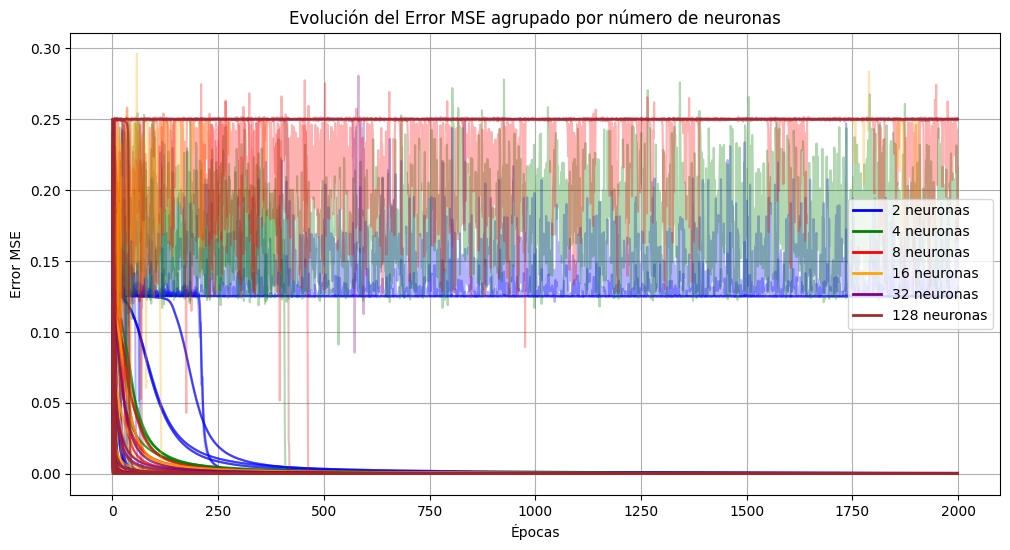

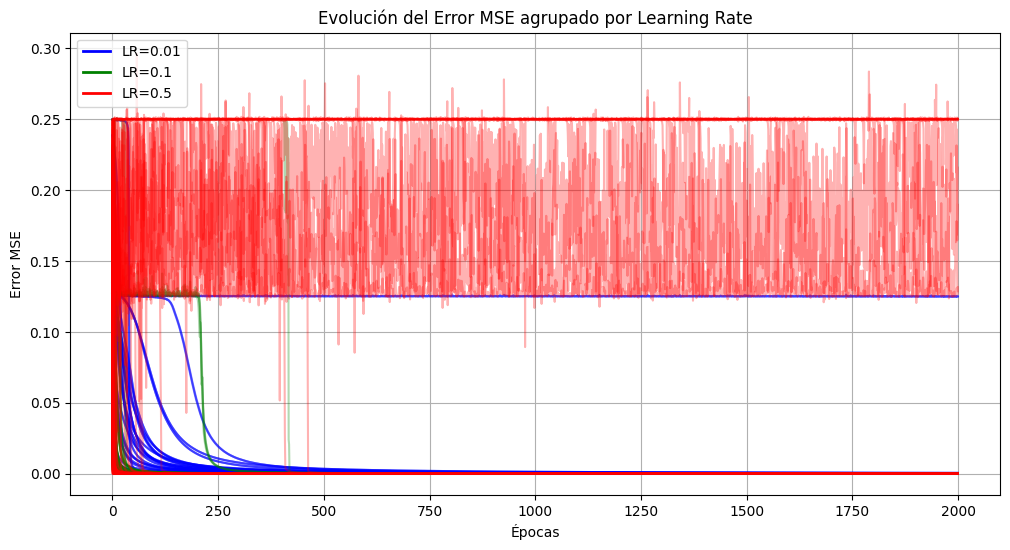

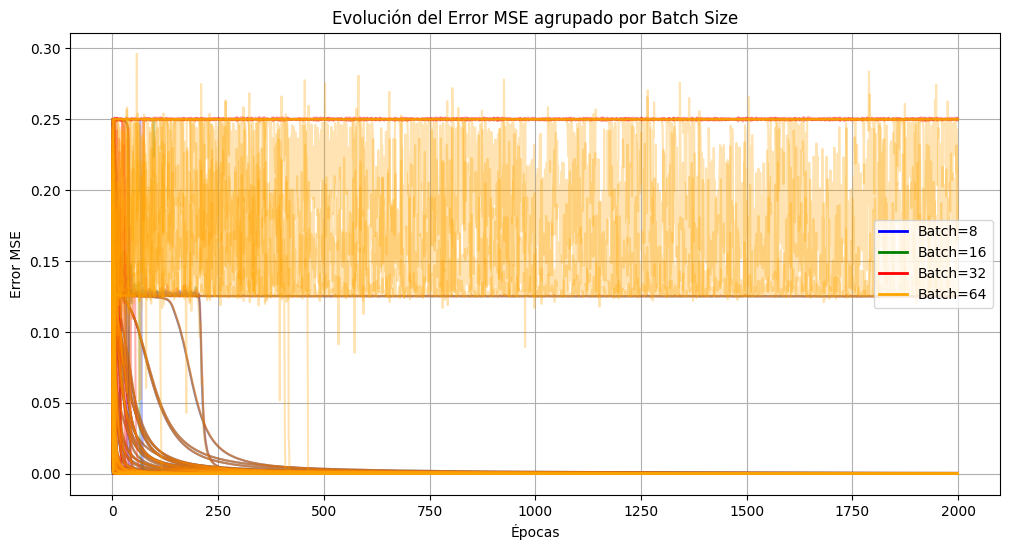

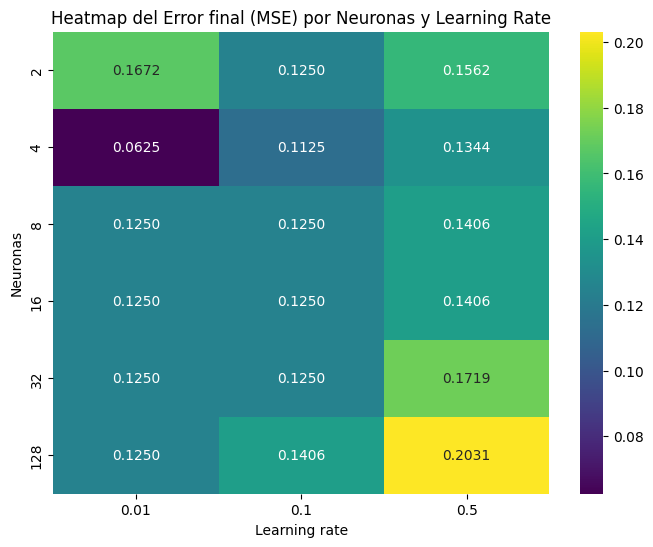

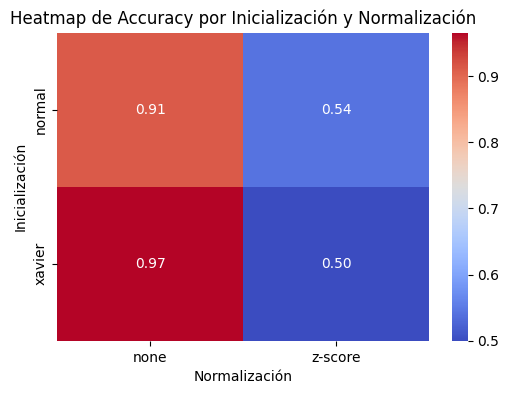

In [17]:
# Mostrar graficas de experimentos
plot_error_subplots(df_resultados)
plot_error_por_neuronas(df_resultados)
plot_error_por_learning_rate(df_resultados)
plot_error_por_batch(df_resultados)
heatmap_error_final(df_resultados)
heatmap_init_norm(df_resultados)
